In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/CORONA_dataset_0-month_3-month-target.csv')

In [39]:
columns_drop = df.isnull().mean()[df.isnull().mean() > 0.7].index
columns_drop
df = df.drop(['UNMC_id', 'CDate', 'futime', 'response_status', 'response_encoded', 'DAS_28_0', 'DAS_28_3' ], axis=1)
df = df.drop(columns_drop, axis=1)

In [40]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()

columns_to_encode = ['grp', 'init_group', 'gender', 'newsmoker', 'drinker', 'ara_func_class', 'final_education', 'race_grp']

# Using .fit_transform function to fit label
for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])


In [41]:
from sklearn.impute import KNNImputer

# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=30)

# Impute missing values using KNN
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# df['response_encoded'] = df['response_encoded'].round().astype(int)


In [42]:
def calculate_DAS28_CRP_0(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28_0']) + 0.28*math.sqrt(
        row['swollen_jts_28_0']) + 0.014*row['pt_global_assess_0'] + 0.36*np.log(row['usresultsCRP_0']+1) + 0.96
    return DAS28_CRP

In [43]:
def calculate_DAS28_CRP_3(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28_3']) + 0.28*math.sqrt(
        row['swollen_jts_28_3']) + 0.014*row['pt_global_assess_3'] + 0.36*np.log(row['usresultsCRP_3']+1) + 0.96
    return DAS28_CRP

In [44]:
df['DAS_28_0'] = df.apply(calculate_DAS28_CRP_0, axis=1)
df['DAS_28_3'] = df.apply(calculate_DAS28_CRP_3, axis=1)

In [45]:
def responseClassify(row, baseline='DAS_28_0', next='DAS_28_3'):
    # set threshold
    lower_change = 0.6
    upper_change = 1.2
    change = row[baseline] - row[next]
    if change <= lower_change:
        return "No Response"
    elif (change <= upper_change) & (change > lower_change):
        if row[next] > 5.1:
            return "No Response"
        else:
            return "Moderate"
    elif change > upper_change:
        if row[next] > 3.2:
            return "Moderate"
        else:
            return "Good"
    else:
        return "Unknown"

In [46]:
df['response_status'] = df.apply(responseClassify, axis=1)


In [47]:
value_counts = df['response_status'].value_counts()
print(value_counts)

Moderate       450
No Response    407
Good           372
Name: response_status, dtype: int64


In [48]:
encoding_mapping = {'Moderate': 2, 'Good': 3, 'No Response': 1}

# Apply manual encoding and store the result in a new column
df['response_encoded'] = df['response_status'].map(encoding_mapping)

In [49]:
df = df.drop(['tender_jts_28_3', 'swollen_jts_28_3', 'pt_global_assess_3', 'usresultsCRP_3', 'DAS_28_0', 'DAS_28_3', 'weight', 'pt_pain', 'ccpstatus_b', 'response_status' ], axis=1)

In [17]:
# from H2O variable importance
df = df[['response_encoded', 'usresultsCRP_0', 'usresultsIgA', 'tender_jts_28_0', 'ndmardused', 'pres_pred', 'pres_mtx', 'rfstatus_b', 'nonpresNSAIDs_use', 'pres_imuran', 'NSAIDs_use', 'pres_plaquenil', 'hxstroke', 'ethnicity', 'newsmoker', 'final_education', 'ara_func_class', 'pt_global_assess_0', 'di', 'usresultsCCP3', 'grp']]


In [50]:
#mix of LIME and H2O
df = df[['response_encoded', 'usresultsCRP_0', 'usresultsIgA', 'tender_jts_28_0', 'pres_pred',  'nonpresNSAIDs_use',  'NSAIDs_use',  'hxstroke',   'final_education', 'ara_func_class', 'pt_global_assess_0', 'di', 'usresultsCCP3', 'grp', 'swollen_jts_28_0',  'BMI', 'pres_minocin', 'usresultsRF', 'seatedbp1', 'usresultsIgM', 'drinksperwk', 'usresultsIgG',  'hxhtn',
'md_global_assess', 'num_tnf', 'hxunstab_ang', 'age', 'seatedbp2']]


In [106]:
df = df.drop(['ethnicity', 'race_grp', 'num_nontnf', 'rfstatus_b', 'duration_ra', 'usresultsCCP3', 'hxdiabetes', 'hxcopd', 'hxmi', 'hxother_cv', 'ndmardused'], axis=1)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   response_encoded    1229 non-null   int64  
 1   usresultsCRP_0      1229 non-null   float64
 2   usresultsIgA        1229 non-null   float64
 3   tender_jts_28_0     1229 non-null   float64
 4   pres_pred           1229 non-null   float64
 5   nonpresNSAIDs_use   1229 non-null   float64
 6   NSAIDs_use          1229 non-null   float64
 7   hxstroke            1229 non-null   float64
 8   final_education     1229 non-null   float64
 9   ara_func_class      1229 non-null   float64
 10  pt_global_assess_0  1229 non-null   float64
 11  di                  1229 non-null   float64
 12  usresultsCCP3       1229 non-null   float64
 13  grp                 1229 non-null   float64
 14  swollen_jts_28_0    1229 non-null   float64
 15  BMI                 1229 non-null   float64
 16  pres_m

In [52]:
!pip install h2o
import h2o
h2o.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,35 mins 34 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_7j58tm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.156 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [53]:
h2o_df = h2o.H2OFrame(df)

#preview
h2o_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


response_encoded,usresultsCRP_0,usresultsIgA,tender_jts_28_0,pres_pred,nonpresNSAIDs_use,NSAIDs_use,hxstroke,final_education,ara_func_class,pt_global_assess_0,di,usresultsCCP3,grp,swollen_jts_28_0,BMI,pres_minocin,usresultsRF,seatedbp1,usresultsIgM,drinksperwk,usresultsIgG,hxhtn,md_global_assess,num_tnf,hxunstab_ang,age,seatedbp2
2,17.13,207,27,0,1,0,0,0,1,55,1.375,19,4,6,33.9829,0,18.2,128,24,0,826,1,50,3,0,59,82
2,5.56,469,8,1,1,0,0,0,2,90,1.28571,251,4,10,20.2204,0,339.8,140,114,0.233333,1260,0,70,1,0,51,90
3,1.64,144,3,0,0,1,0,0,0,25,0.285714,15,2,4,31.3777,0,56.4,122,113,0.7,886,0,50,0,0,54,88
1,0.43,342,9,1,1,1,0,0,1,40,0.25,177,0,10,21.609,0,12.7,143,60,0,752,1,50,2,0,67,68
2,49.55,338,6,1,1,0,0,0,1,20,0.142857,242,6,8,20.0149,0,20.9,130,66,0,714,1,50,2,0,68,71
3,0.19,179,4,1,0,1,0,0,1,70,0,15,6,8,20.939,0,8.2,113,176,3,1210,0,35,1,0,63,68
3,17.73,523,6,0,0,1,0,2,1,95,2,251,0,10,22.8475,0,813,118,279,0,1310,0,65,3,0,70,80
1,3.53,207,17,0,1,0,0,0,1,25,0.125,251,4,2,37.9481,0,446.1,99,247,2,1110,1,40,1,0,63,64
2,2.41,238,11,0,0,0,0,0,1,30,0,251,6,4,37.5051,0,1153,112,291,0.466667,1080,1,35,1,0,64,70
1,1.81,153,1,0,0,0,0,2,0,55,0,251,0,6,26.0879,0,119,118,262,2,1200,0,35,2,0,47,60


In [54]:
train, test = h2o_df.split_frame(ratios=[0.75], seed=121)
#define X and y
X = train.columns
y = 'response_encoded'
X.remove(y)

In [55]:
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [56]:
from h2o.automl import H2OAutoML

# aml = H2OAutoML(max_models=20, seed=1, nfolds=5,
#                                  keep_cross_validation_predictions=True)

# aml = H2OAutoML(max_models=20, 
#                 seed=121, 
#                 stopping_metric='AUC',     #for classification
#                 nfolds=5, 
#                 balance_classes=True,
#                 keep_cross_validation_predictions=True)

aml = H2OAutoML(max_models=20, 
                seed=121, 
                nfolds=5, 
                balance_classes=True,
                keep_cross_validation_predictions=True,
                max_runtime_secs=3600)

aml.train(x=X, 
          y=y, 
          training_frame=train)


# aml.train(x=X_train.columns.to_list(), y='response_status', training_frame=train_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_2_20230509_223137_model_1


Model Summary: 
    number_of_trees
--  -----------------
    30

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.18315611006296195
RMSE: 0.4279674170576096
LogLoss: 0.5478240952893014
Mean Per-Class Error: 0.11481105777276125
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2    3    Error      Rate
---  ---  ---  ---------  ---------
271  26   7    0.108553   33 / 304
15   311  13   0.0825959  28 / 339
23   19   232  0.153285   42 / 274
309  356  252  0.112323   103 / 917

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.887677
2    0.983642
3    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.395317472588009
RMSE: 0.6287427714002038
LogLoss: 1.0637959927734064
Mean Per-Class Error: 0.5178893123470347
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2    3    Error     Rate
---  ---  ---  --------  ---------
152  99   53   0.5       152 / 304
85   181  73   0.466077  158 / 339
74   87   113  0.587591  161 / 274
311  367  239  0.513631  471 / 917

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.486369
2    0.774264
3    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.486422  0.0304587   0.434783      0.48913       0.513661      0.502732      0.491803
auc                      nan       0           nan           nan           nan           nan           nan
err                      0.513578  0.0304587   0.565217      0.51087       0.486339      0.497268      0.508197
err_count                94.2      5.80517     104           94            89            91            93
logloss                  1.06379   0.0293502   1.10128       1.03266       1.07403       1.03513       1.07583
max_per_class_error      0.587575  0.0454884   0.6           0.603774      0.641509      0.574074      0.518518
mean_per_class_accuracy  0.483772  0.028441    0.434722      0.486621      0.507068      0.498098      0.492353
mean_per_class_error     0.516228  0.028441    0.565278      0.513379      0.492932      0.501902      0.507647
mse                      0.39531   0.0104395   0.410461      0.387291      0.396582      0.383857      0.398357
pr_auc                   nan       0           nan           nan           nan           nan           nan
r2                       0.369672  0.0312849   0.390502      0.340039      0.394053      0.392601      0.331165
rmse                     0.628693  0.00828523  0.640672      0.622327      0.629748      0.619562      0.631155

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_logloss    training_classification_error    training_auc    training_pr_auc
--  -------------------  ----------  -----------------  ---------------  ------------------  -------------------------------  --------------  -----------------
    2023-05-09 22:33:07  1.220 sec   0                  0.666667         1.09861             0.7012      

In [57]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid_1_AutoML_2_20230509_223137_model_1,0.517889,1.0638,0.628743,0.395317
XGBoost_2_AutoML_2_20230509_223137,0.519766,1.12756,0.635388,0.403719
StackedEnsemble_BestOfFamily_1_AutoML_2_20230509_223137,0.521835,1.02938,0.6322,0.399677
DRF_1_AutoML_2_20230509_223137,0.523363,1.04179,0.634159,0.402158
GBM_grid_1_AutoML_2_20230509_223137_model_2,0.523923,1.02919,0.632097,0.399546
XGBoost_3_AutoML_2_20230509_223137,0.526165,1.09219,0.629904,0.39678
XRT_1_AutoML_2_20230509_223137,0.530054,1.0414,0.634273,0.402303
GBM_5_AutoML_2_20230509_223137,0.53125,1.05011,0.633654,0.401517
StackedEnsemble_AllModels_1_AutoML_2_20230509_223137,0.53125,1.03437,0.635855,0.404312
GBM_4_AutoML_2_20230509_223137,0.532334,1.05868,0.634688,0.402829


In [58]:
varimp = aml.varimp(use_pandas=True)


In [59]:
varimp

,GLM_1,DeepLearning_1,DeepLearning_grid_3_model_1,DeepLearning_grid_1_model_1,DeepLearning_grid_2_model_1,GBM_grid_1_model_2,GBM_3,GBM_5,XGBoost_grid_1_model_3,XGBoost_grid_1_model_2,XGBoost_1,XGBoost_3,XGBoost_2,XGBoost_grid_1_model_1,GBM_2,GBM_4,XRT_1,DRF_1,GBM_grid_1_model_1,GBM_1
hxunstab_ang,0.034192,0.036737,0.036462,0.046847,0.035952,0.000000,0.000000,0.001041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000469,0.000814,0.000000,0.000000
pres_minocin,0.036544,0.034774,0.023518,0.027684,0.017503,0.000000,0.000000,0.000121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000352,0.000666,0.000000,0.000000
hxstroke,0.020292,0.043864,0.029204,0.030257,0.022461,0.000000,0.000000,0.000573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000548,0.000863,0.000000,0.000000
hxhtn,0.048192,0.041692,0.039470,0.038499,0.038270,0.014647,0.010755,0.007477,0.008436,0.009668,0.007508,0.007578,0.011224,0.010551,0.013713,0.010601,0.008799,0.012608,0.015616,0.014165
ara_func_class,0.048325,0.039961,0.038367,0.033475,0.038103,0.014557,0.015118,0.011926,0.013105,0.012034,0.008438,0.010909,0.007030,0.010934,0.010123,0.015522,0.016180,0.022407,0.018316,0.009981
final_education,0.019945,0.037345,0.038604,0.034973,0.041997,0.006102,0.012302,0.015641,0.008952,0.009240,0.012299,0.009748,0.010563,0.006976,0.010503,0.012350,0.015292,0.015280,0.003094,0.010957
nonpresNSAIDs_use,0.013184,0.023525,0.035751,0.030835,0.035397,0.010122,0.010796,0.006533,0.005664,0.004471,0.004486,0.004891,0.004992,0.005211,0.007690,0.010552,0.006299,0.011033,0.001217,0.001743
swollen_jts_28_0,0.059101,0.034241,0.042574,0.041924,0.041639,0.045404,0.069553,0.059831,0.055691,0.059470,0.057895,0.057677,0.052390,0.076153,0.069472,0.084213,0.068202,0.069140,0.103676,0.074357
BMI,0.066869,0.045288,0.038173,0.037138,0.040890,0.077985,0.075556,0.076940,0.076185,0.086559,0.081782,0.082371,0.076740,0.081282,0.078764,0.062016,0.062329,0.062902,0.081383,0.081494
tender_jts_28_0,0.065606,0.029669,0.042309,0.040314,0.043197,0.083334,0.094094,0.076453,0.080148,0.064081,0.059178,0.062243,0.058903,0.068373,0.071464,0.065209,0.073819,0.071420,0.110075,0.095410


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_grid_1_AutoML_2_20230509_223137_model_1

1,2,3,Error,Rate
41.0,44.0,18.0,0.6019417,62 / 103
28.0,60.0,23.0,0.4594595,51 / 111
35.0,32.0,31.0,0.6836735,67 / 98
104.0,136.0,72.0,0.5769231,180 / 312


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

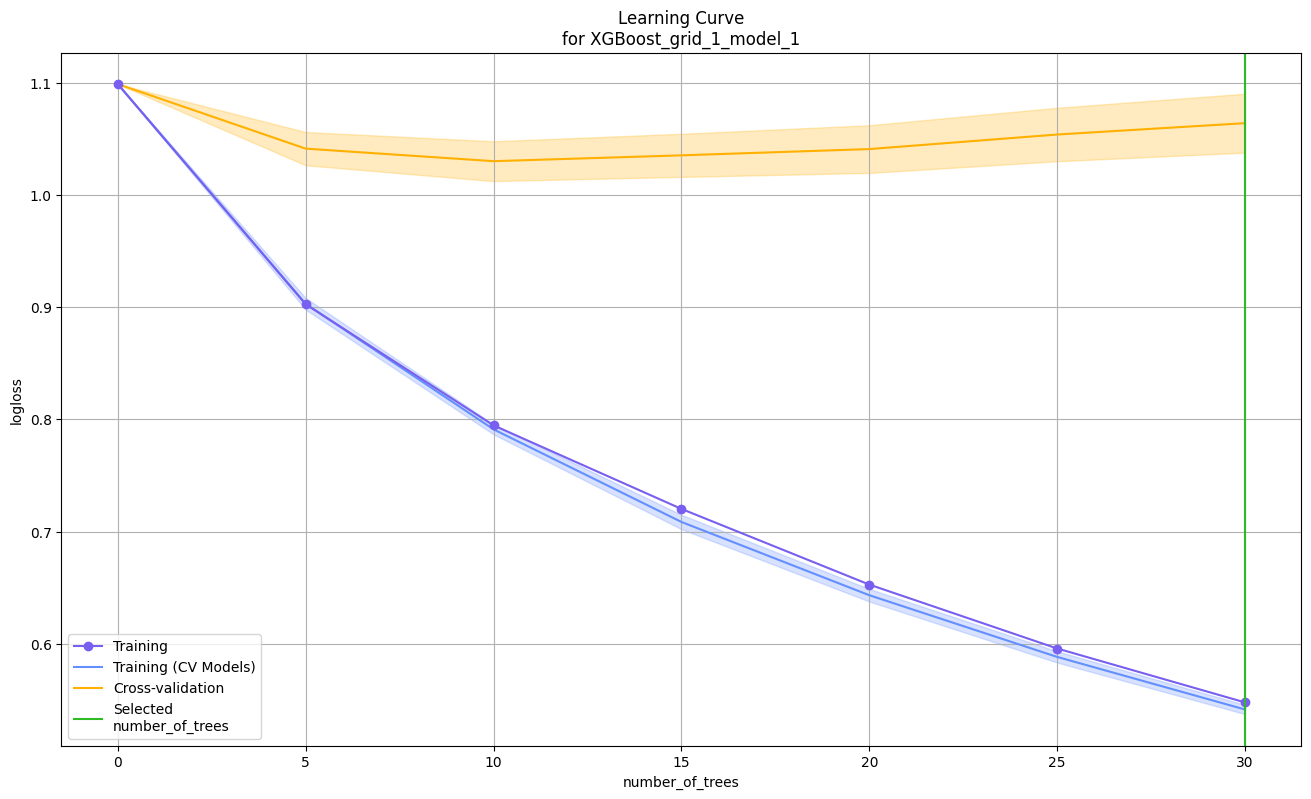

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

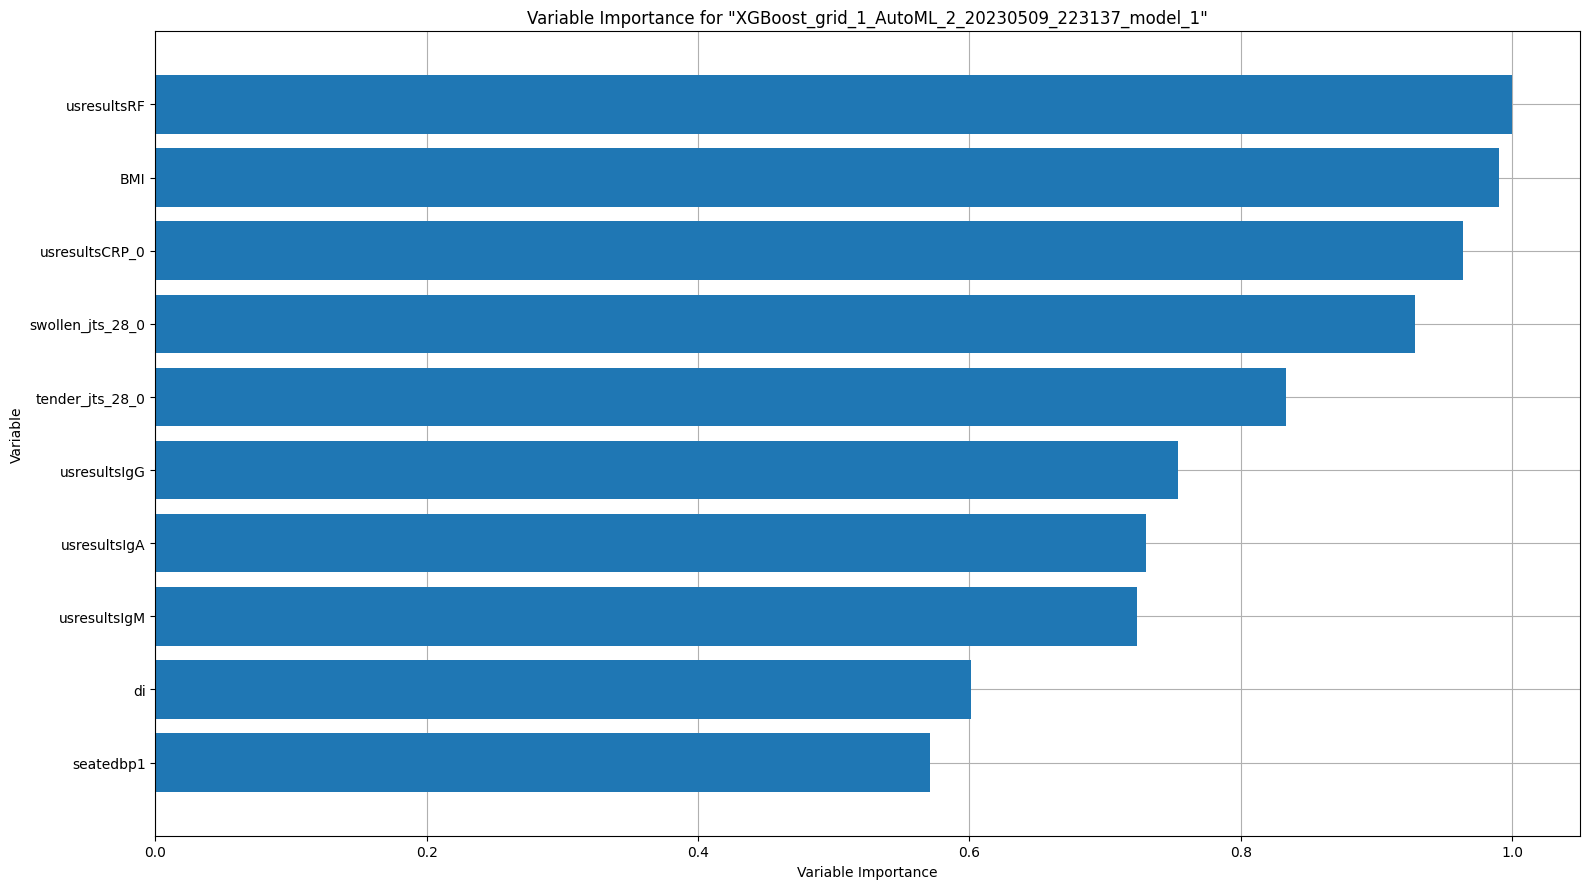

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

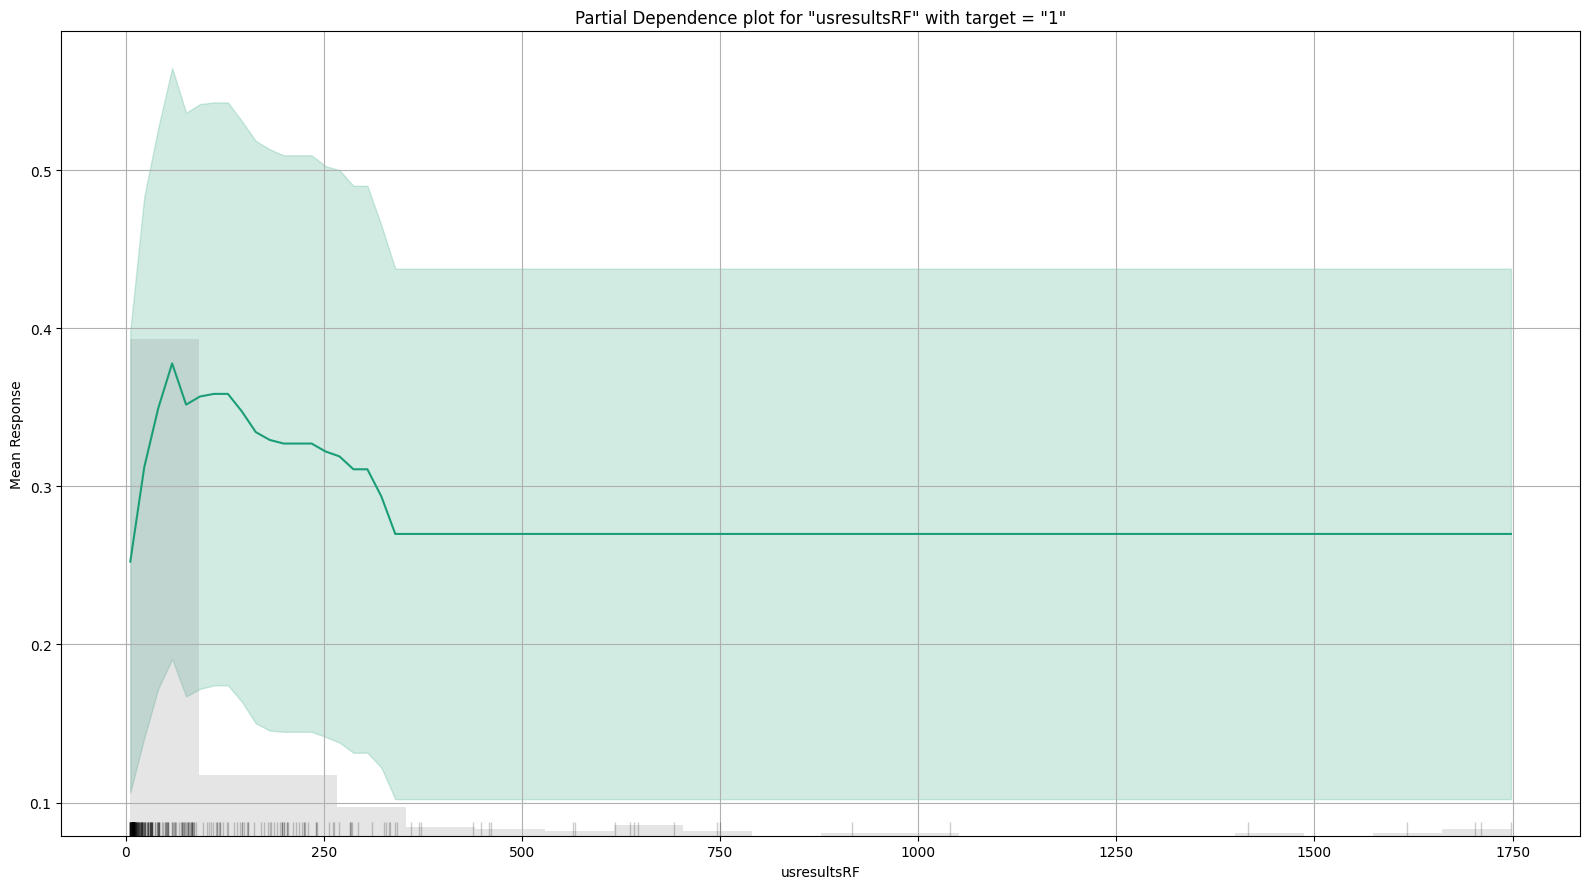

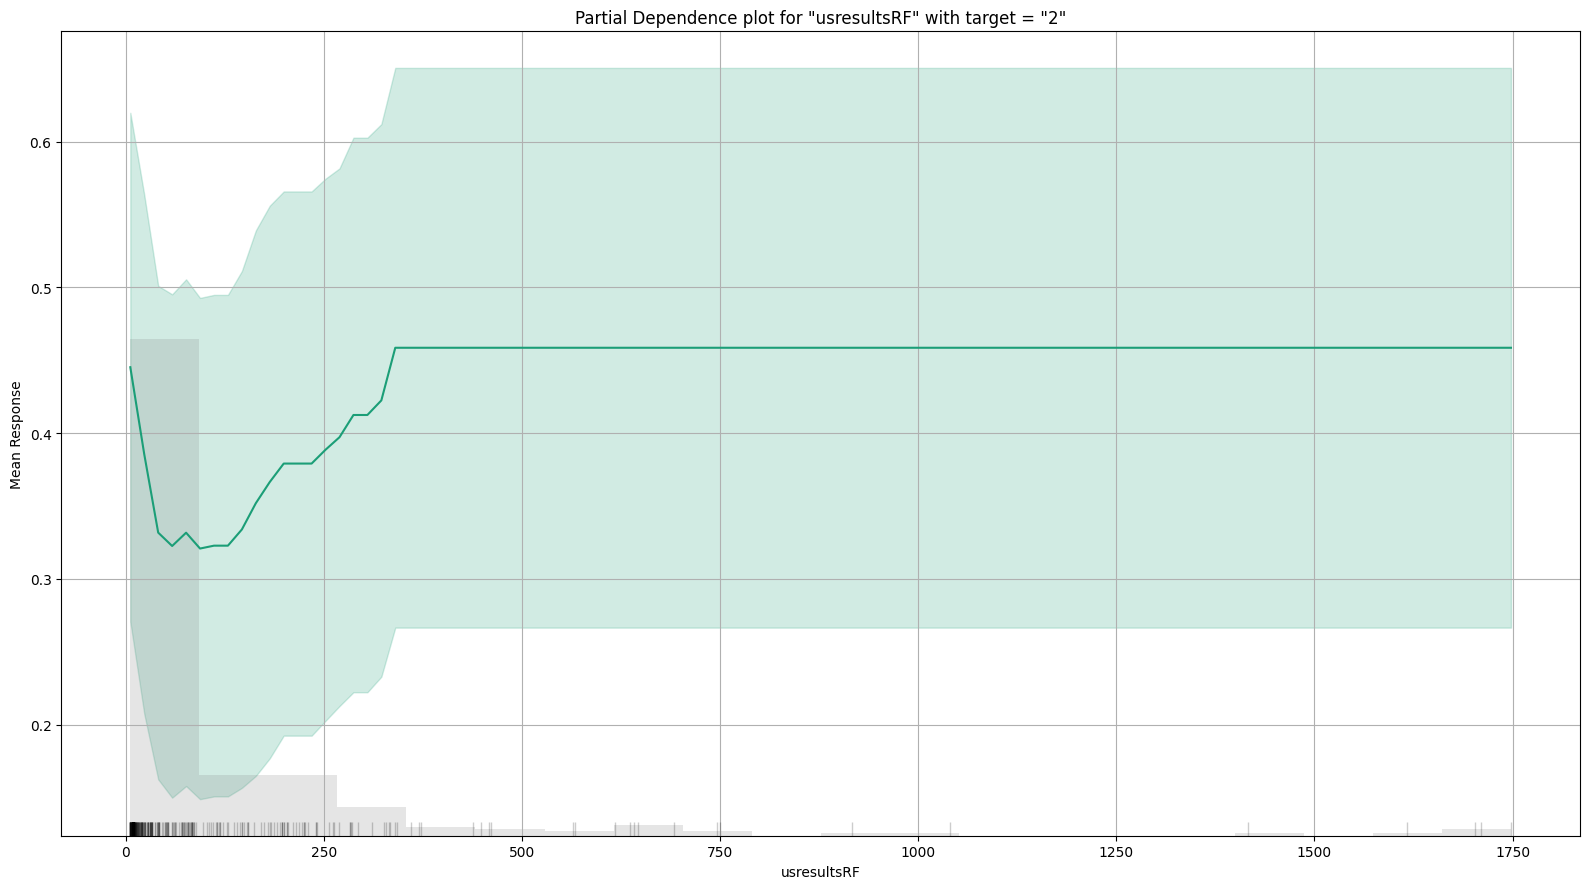

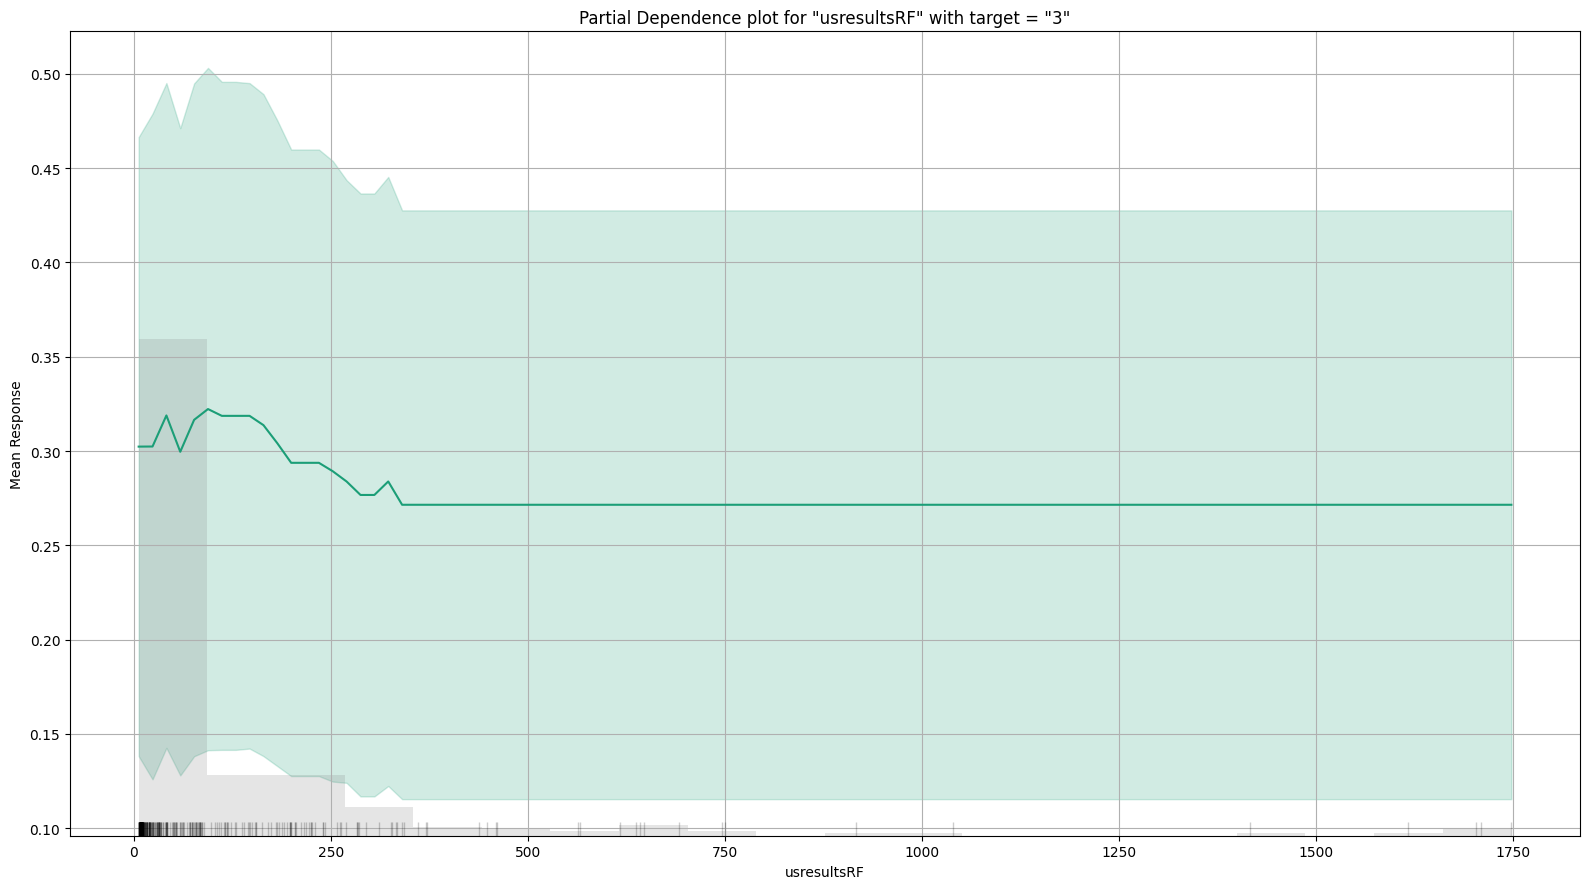

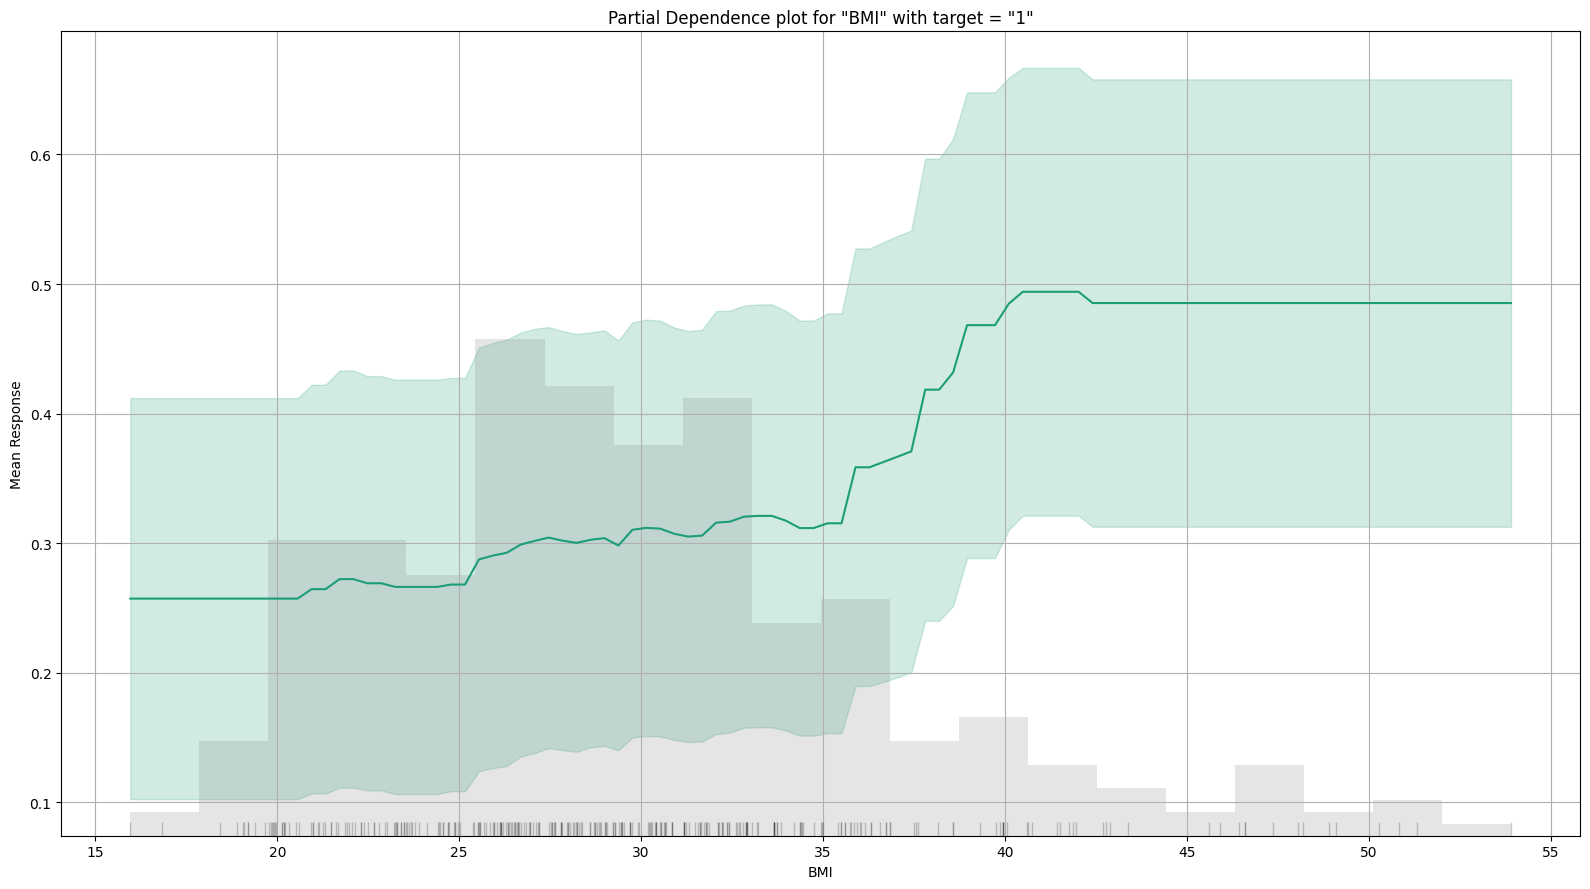

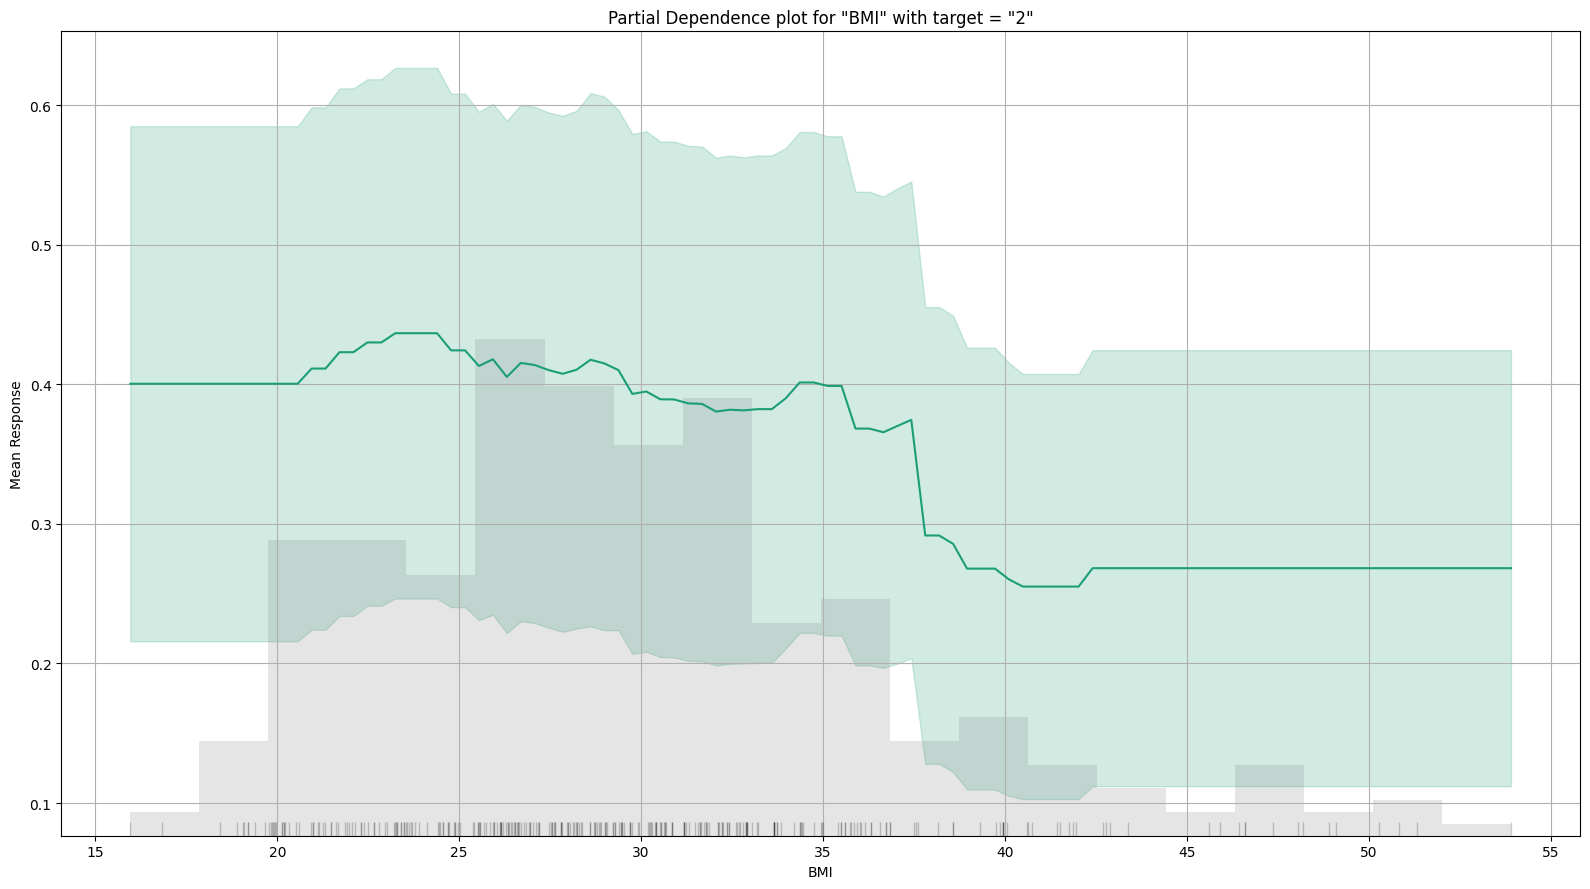

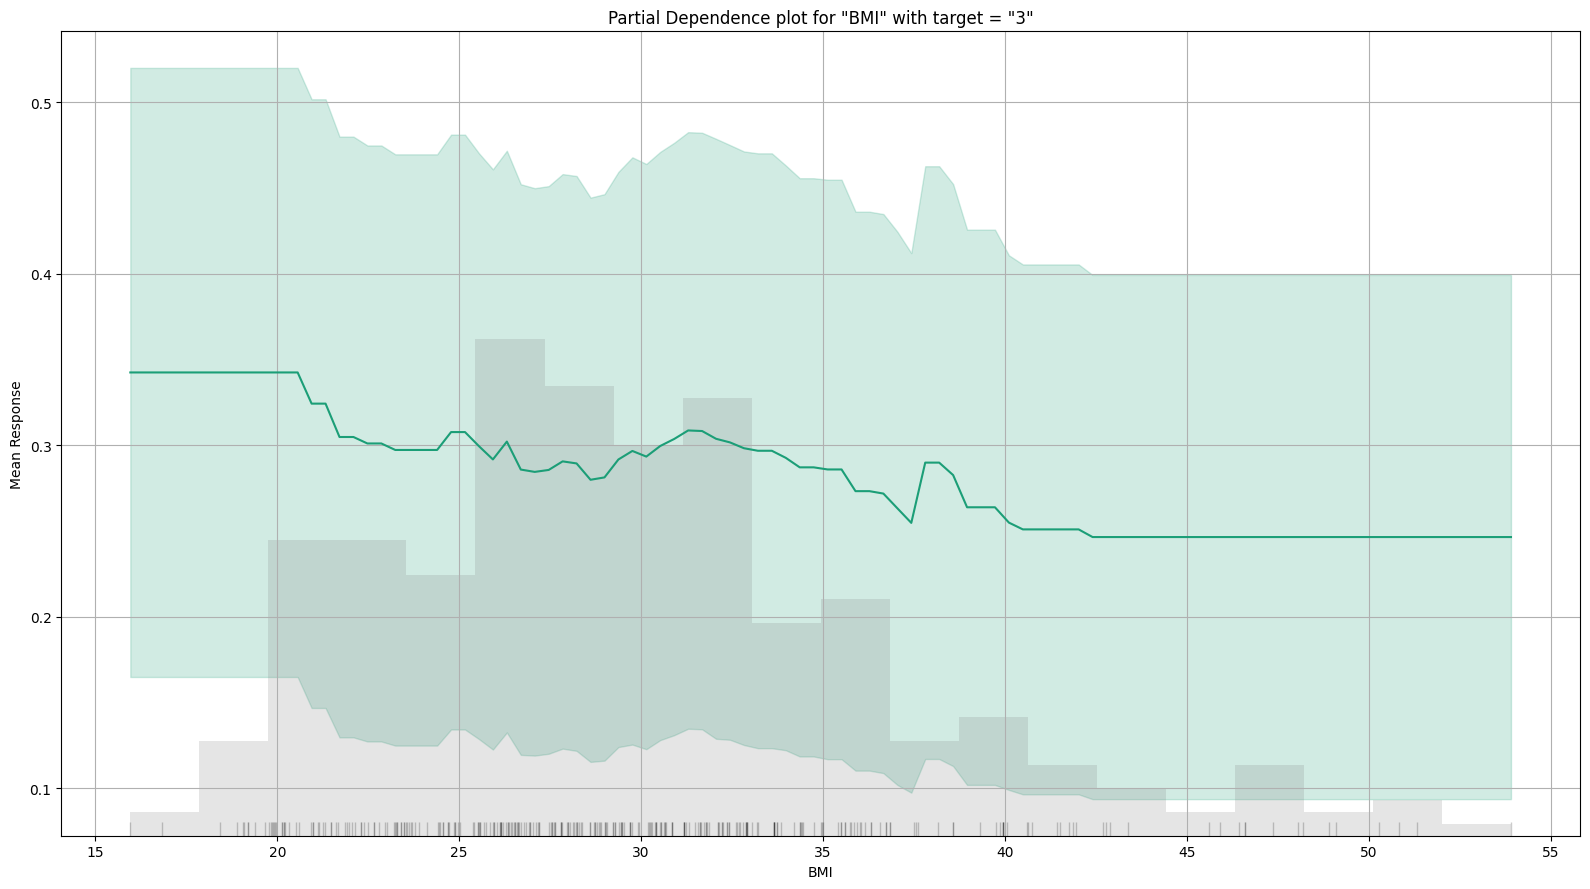

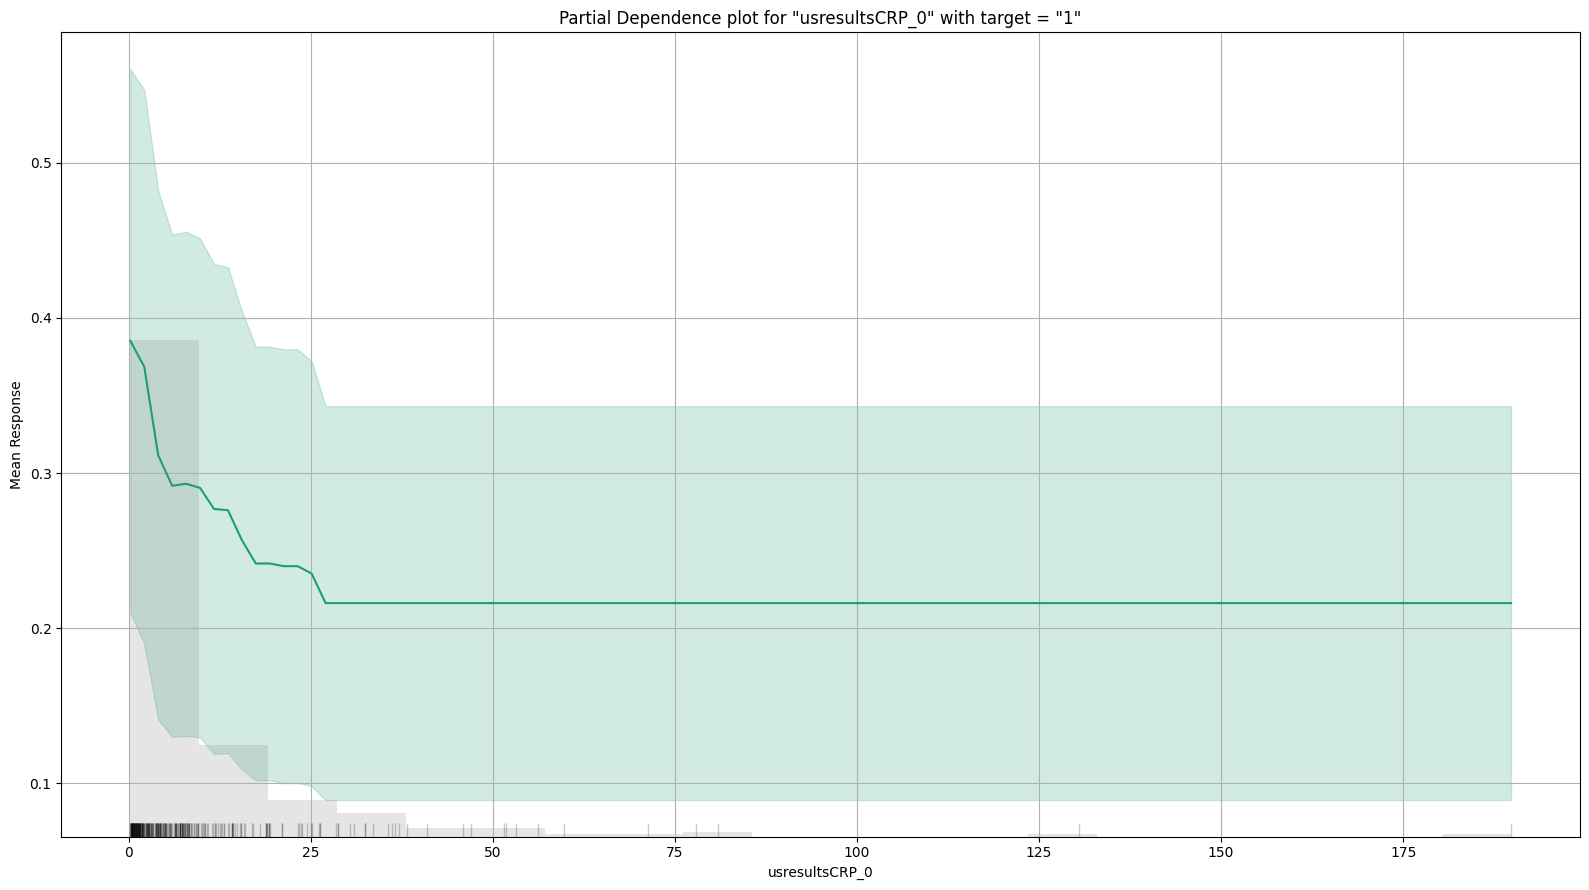

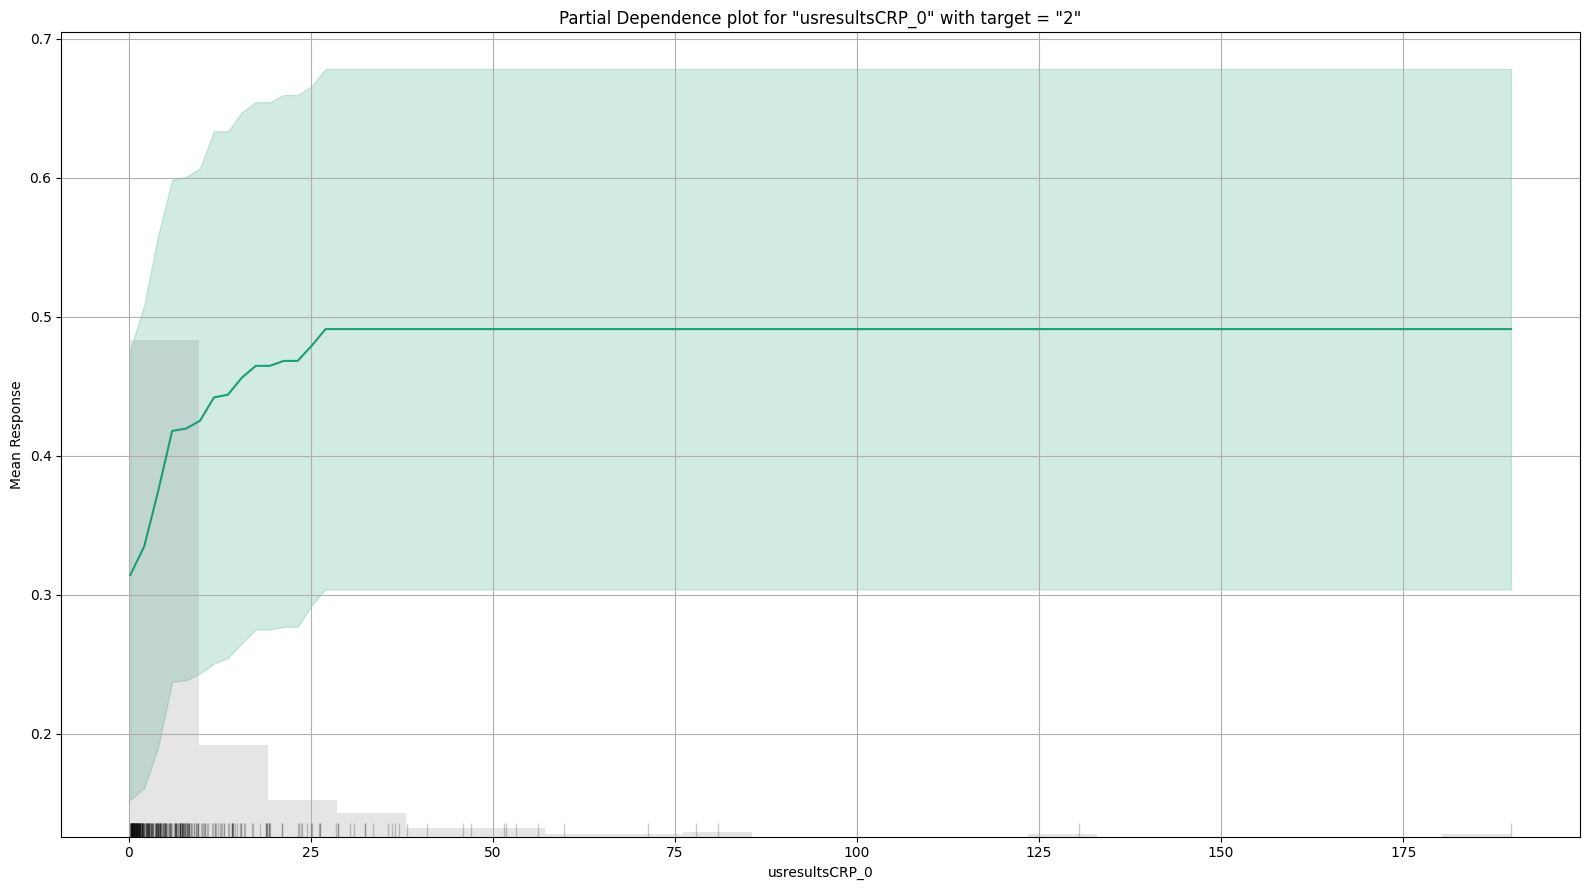

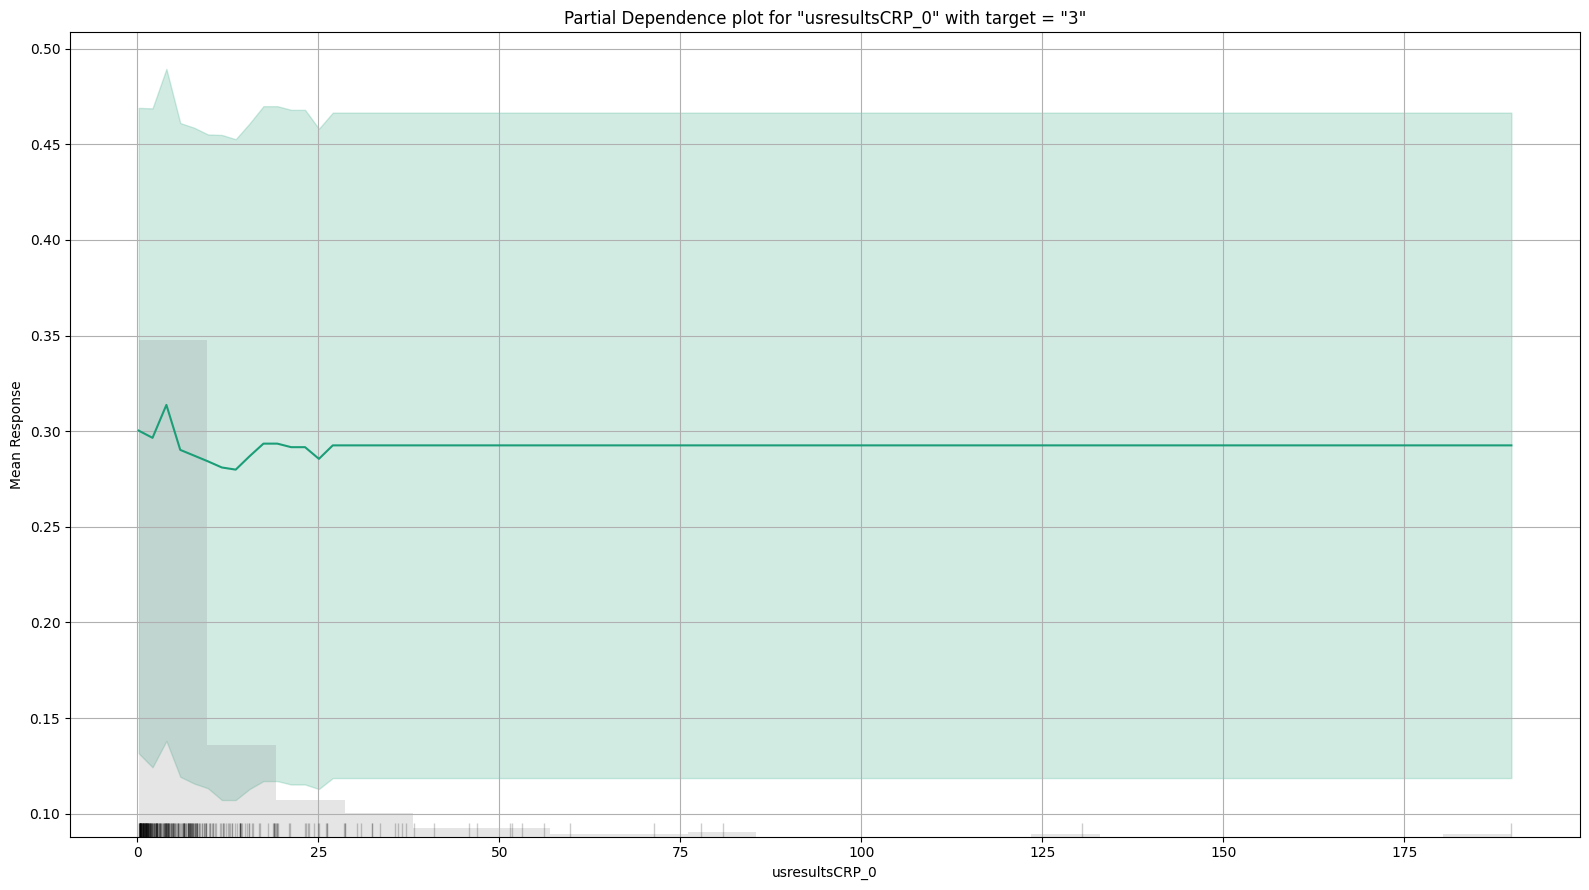

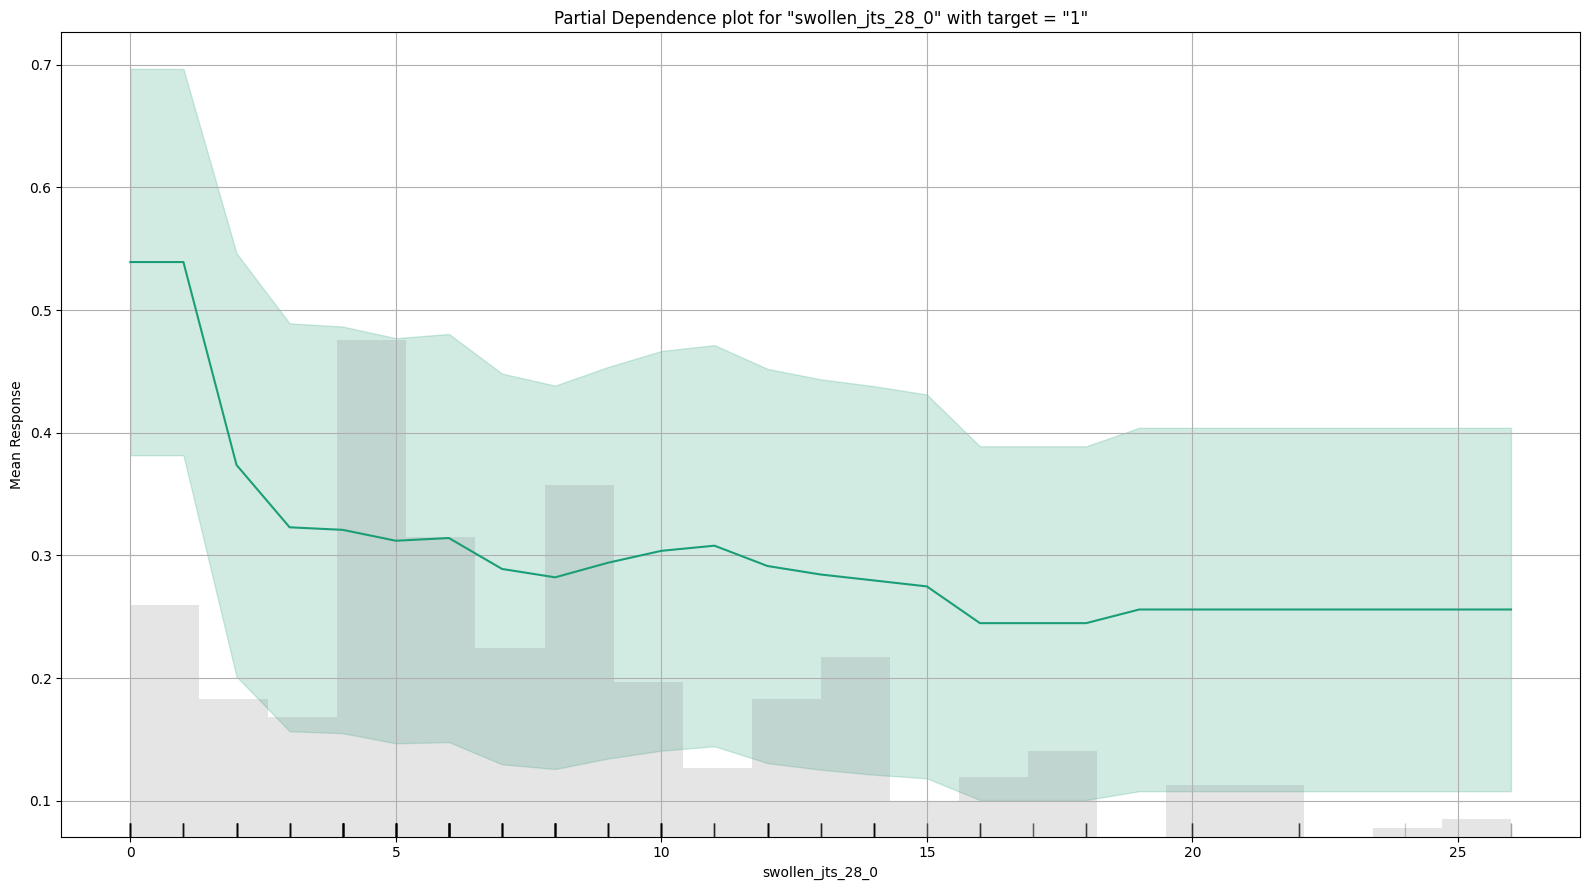

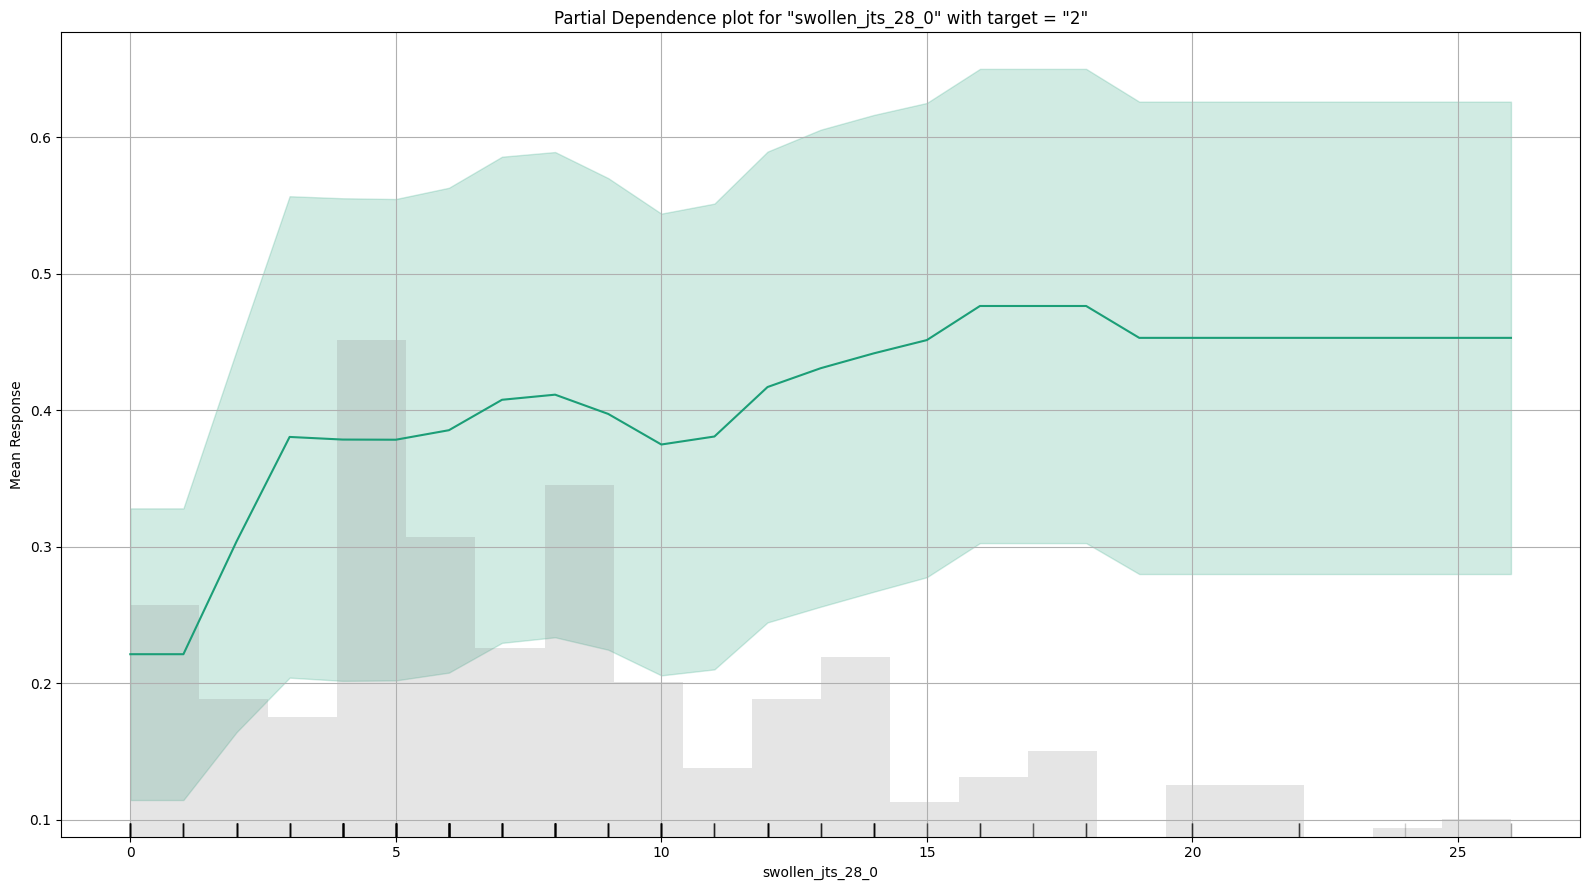

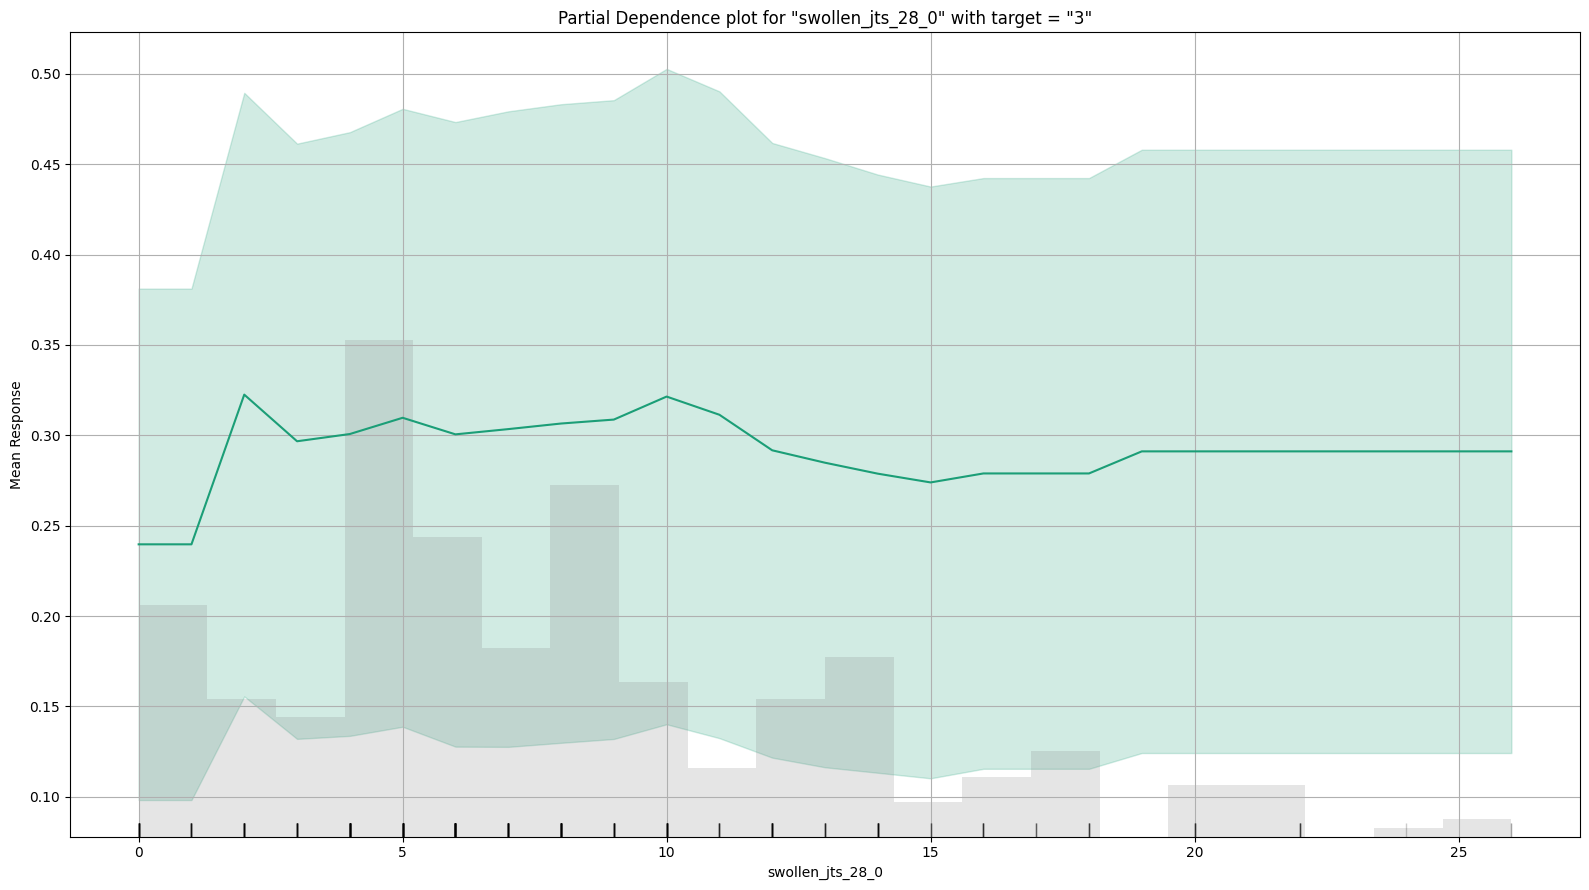

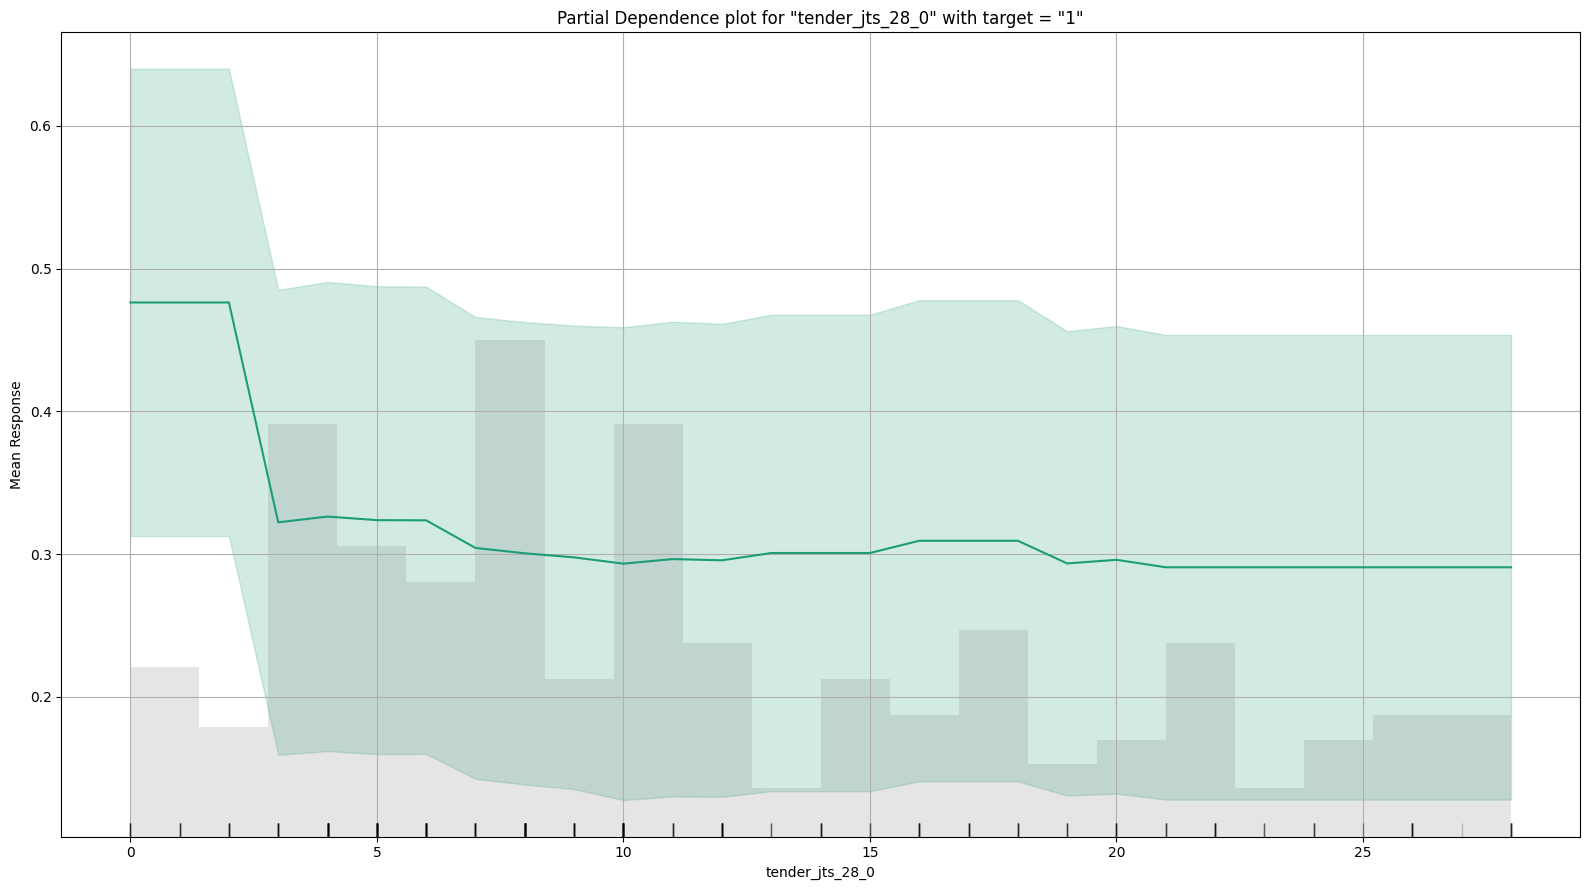

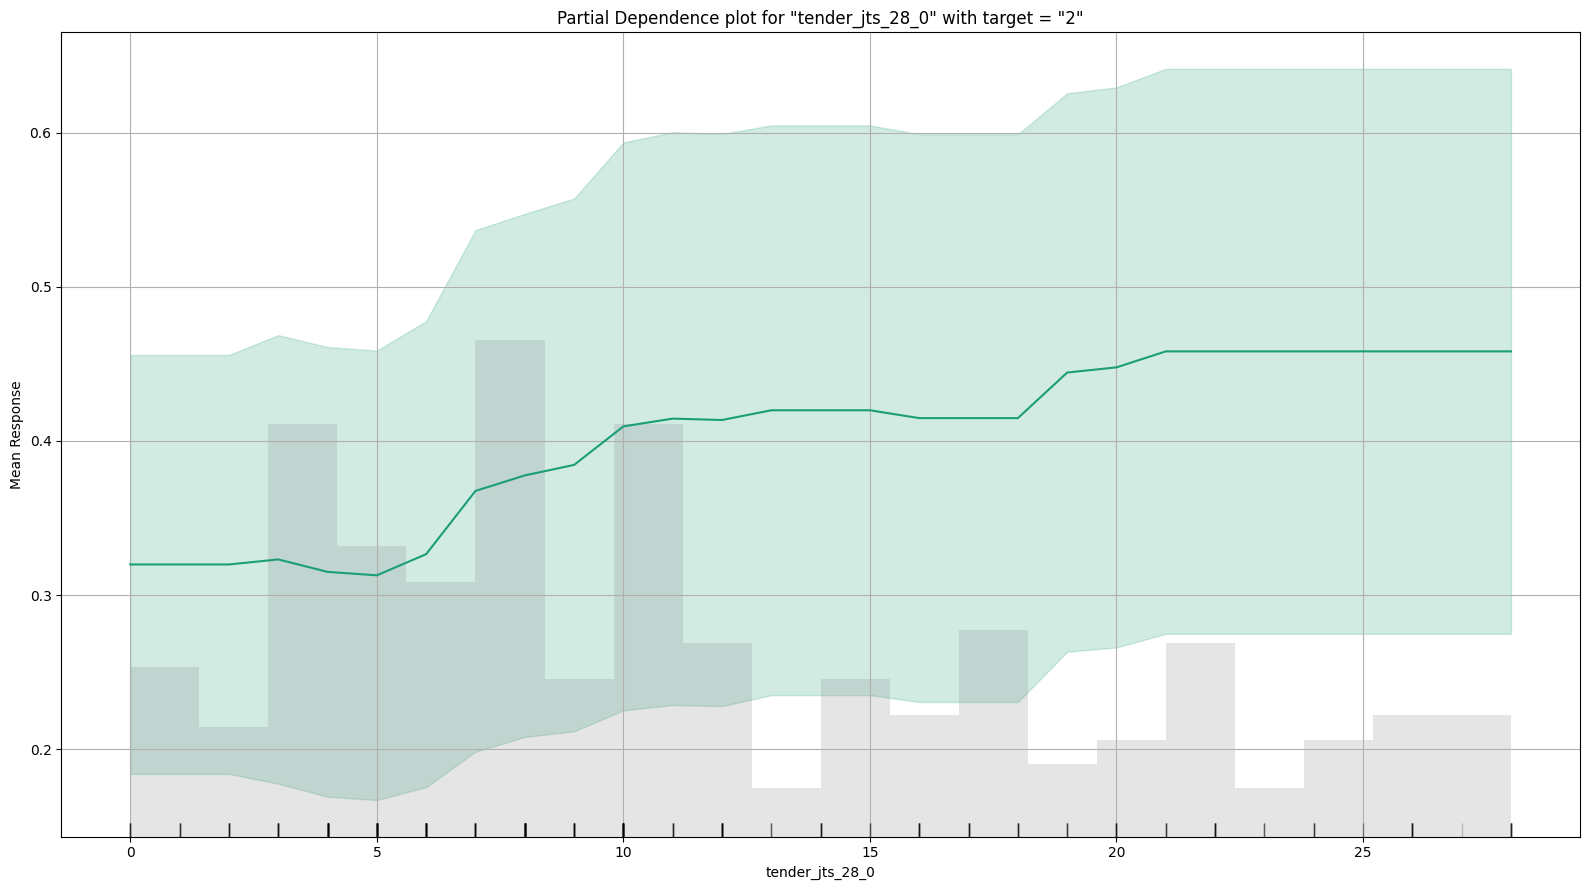

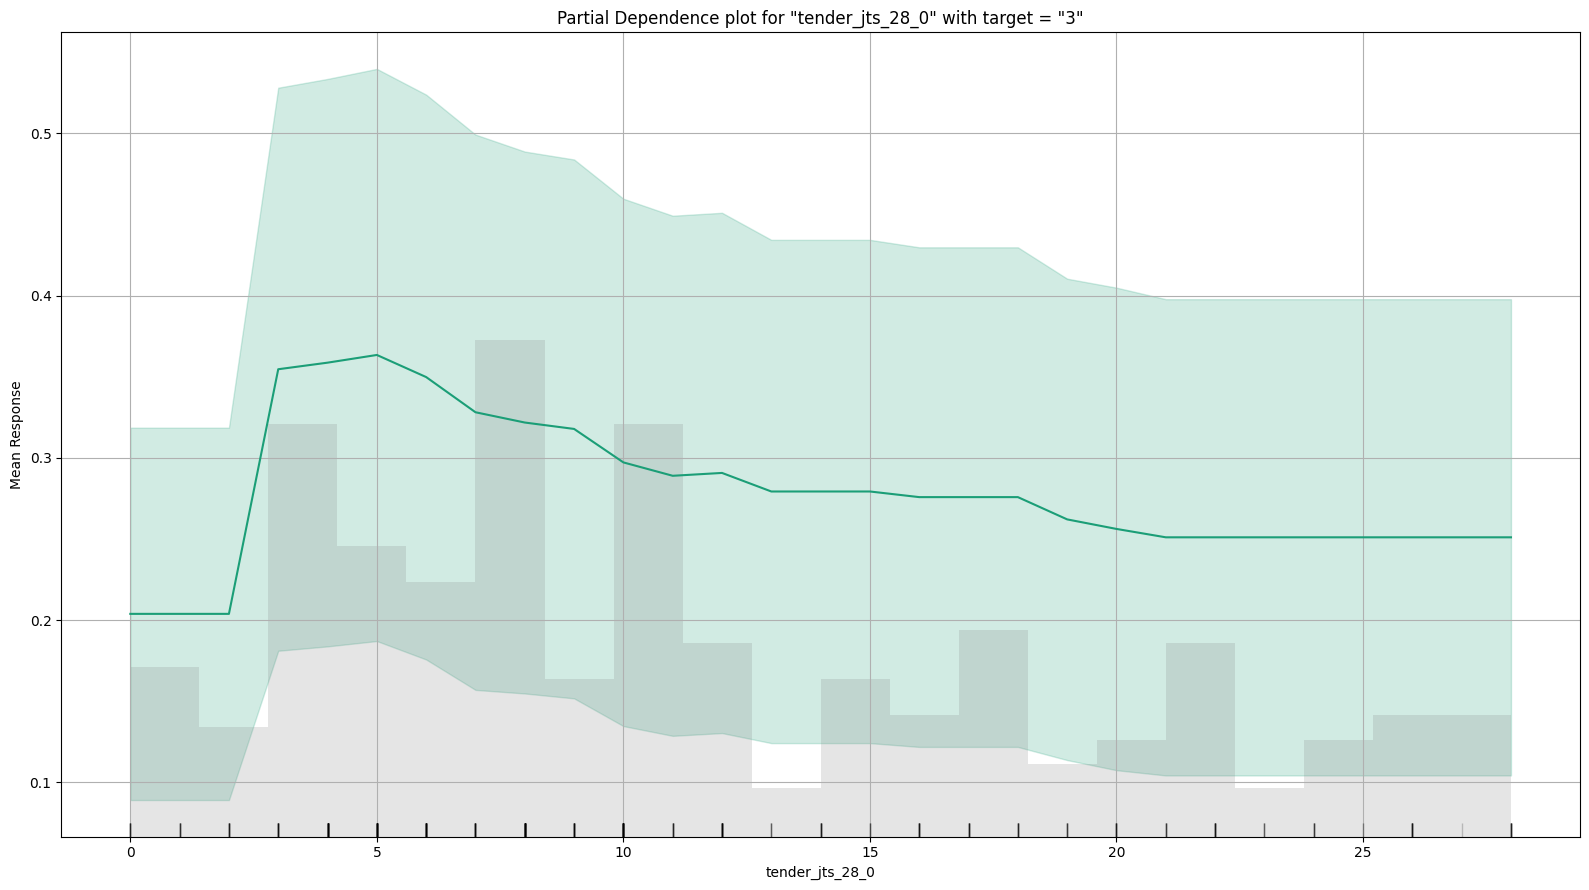

In [60]:
exm = aml.leader.explain(test)


In [61]:
preds = aml.leader.predict(test)


xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [62]:
df = test.cbind(preds)
df = h2o.as_list(df)
preds = df[['response_encoded', 'predict']].head(20)
preds

,response_encoded,predict
0,2,2
1,3,2
2,3,1
3,2,2
4,1,3
5,1,3
6,2,2
7,3,2
8,2,1
9,3,1


In [63]:
!pip install lime
import lime
import lime.lime_tabular

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
feature_names = train.columns[0: -1]
feature_names

['response_encoded',
 'usresultsCRP_0',
 'usresultsIgA',
 'tender_jts_28_0',
 'pres_pred',
 'nonpresNSAIDs_use',
 'NSAIDs_use',
 'hxstroke',
 'final_education',
 'ara_func_class',
 'pt_global_assess_0',
 'di',
 'usresultsCCP3',
 'grp',
 'swollen_jts_28_0',
 'BMI',
 'pres_minocin',
 'usresultsRF',
 'seatedbp1',
 'usresultsIgM',
 'drinksperwk',
 'usresultsIgG',
 'hxhtn',
 'md_global_assess',
 'num_tnf',
 'hxunstab_ang',
 'age']

In [65]:
train_features_numpy = train[feature_names].as_data_frame().values
train_features_numpy

array([[  2.        ,  17.13      , 207.        , ...,   3.        ,
          0.        ,  59.        ],
       [  3.        ,   1.64      , 144.        , ...,   0.        ,
          0.        ,  54.        ],
       [  1.        ,   0.43      , 342.        , ...,   2.        ,
          0.        ,  67.        ],
       ...,
       [  3.        ,   0.92      , 163.        , ...,   0.        ,
          0.        ,  61.        ],
       [  3.        ,  12.67      , 251.66666667, ...,   0.        ,
          0.        ,  57.        ],
       [  3.        ,   3.9       , 198.        , ...,   0.        ,
          0.        ,  23.        ]])

In [66]:
#define LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(train_features_numpy, 
                                                   feature_names = feature_names,
                                                   mode='classification')

In [67]:
def findPrediction(instance):

 #instance will be in type of numpy
 df = pd.DataFrame(data = instance, columns = feature_names)
 hf = h2o.H2OFrame(df)
 predictions = aml.leader.predict(hf).as_data_frame()
 
 #here predictions object is 3 columned data frame. 1st column is class prediction and others are probabilities
 #lime needs just prediction probabilities
 
 predictions = predictions.iloc[:,1:].values
 return predictions

In [68]:
idx = 100
test_df = test.as_data_frame()
test_numpy = test_df.iloc[idx].values[0:-1]

In [69]:

test_numpy = np.delete(test_numpy, np.where(test_numpy == 'No Response'))
test_numpy


<ipython-input-69-a33a13b8d92e>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  test_numpy = np.delete(test_numpy, np.where(test_numpy == 'No Response'))


array([1.00000000e+00, 2.57000000e+00, 2.99000000e+02, 1.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.00000000e+00, 1.00000000e+00, 9.00000000e+01, 1.00000000e+00,
       2.51000000e+02, 4.00000000e+00, 3.00000000e+00, 3.57332493e+01,
       0.00000000e+00, 7.50000000e+02, 1.20000000e+02, 1.42000000e+02,
       0.00000000e+00, 1.17000000e+03, 1.00000000e+00, 4.00000000e+01,
       3.00000000e+00, 0.00000000e+00, 5.60000000e+01])

In [70]:
exp = explainer.explain_instance(test_numpy, 
                                 findPrediction, 
                                 num_features = len(feature_names))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: | (failed)


OSError: ignored

In [ ]:
exp.show_in_notebook(show_table=True, show_all=True)


In [ ]:
exp.as_list()
